Back in elementary school you learnt the difference between nouns, verbs, adjectives, and adverbs. These "word classes" are not just the idle invention of grammarians, but are useful categories for many language processing tasks. As we will see, they arise from simple analysis of the distribution of words in text. 

Along the way, we'll cover some fundamental techniques in NLP, including sequence labeling, n-gram models, backoff, and evaluation. 

These techniques are useful in many areas, and tagging gives us a simple context in which to present them. We will also see how tagging is the second step in the typical NLP pipeline, following tokenization.

The process of classifying words into their **parts of speech** and labeling them accordingly is known as **part-of-speech tagging**, **POS-tagging**, or **simply tagging**. 

Parts of speech are also known as **word classes** or **lexical categories**. The collection of tags used for a particular task is known as a **tagset**. Our emphasis in this chapter is on exploiting tags, and tagging text automatically.

# 1   Using a Tagger

A part-of-speech tagger, or POS-tagger, processes a sequence of words, and attaches a part of speech tag to each word.

In [1]:
import nltk

In [2]:
text = nltk.word_tokenize("And now for something completely different")
nltk.pos_tag(text)

[('And', 'CC'),
 ('now', 'RB'),
 ('for', 'IN'),
 ('something', 'NN'),
 ('completely', 'RB'),
 ('different', 'JJ')]

Here we see that "And" is "CC", a "coordinating conjunction"; "now" and "completely" are "RB", or "adverbs"; "for" is "IN", a "preposition"; "something" is "NN", a "noun"; and "different" is "JJ", an "adjective".

In [3]:
# NLTK provides documentation for tags 
nltk.help.upenn_tagset('RB')
#Some corpora have README files with tagset documentation, 
#see nltk.corpus.???.readme()

RB: adverb
    occasionally unabatingly maddeningly adventurously professedly
    stirringly prominently technologically magisterially predominately
    swiftly fiscally pitilessly ...


- Def **Homonyms**: each of two or more words having the same spelling or pronunciation but different meanings and origins.

"tear drop" and "to tear a hole"

In [4]:
# this time including some homonyms:
text = nltk.word_tokenize("They refuse to permit us to obtain the refuse permit")
nltk.pos_tag(text)

[('They', 'PRP'),
 ('refuse', 'VBP'),
 ('to', 'TO'),
 ('permit', 'VB'),
 ('us', 'PRP'),
 ('to', 'TO'),
 ('obtain', 'VB'),
 ('the', 'DT'),
 ('refuse', 'NN'),
 ('permit', 'NN')]

Notice that refuse and permit both appear as a present tense verb (VBP) and a noun (NN). E.g. refUSE is a verb meaning "deny," while REFuse is a noun meaning "trash" (i.e. they are not homophones). Thus, we need to know which word is being used in order to pronounce the text correctly. (For this reason, text-to-speech systems usually perform POS-tagging.)

Lexical categories like "noun" and part-of-speech tags like NN seem to have their uses, but the details will be obscure to many readers. You might wonder what justification there is for introducing this extra level of information. Many of these categories arise from superficial analysis the distribution of words in text. Consider the following analysis involving woman (a noun), bought (a verb), over (a preposition), and the (a determiner). The text.similar() method takes a word w, finds all contexts w1w w2, then finds all words w' that appear in the same context

In [5]:
text = nltk.Text(word.lower() for word in nltk.corpus.brown.words())
text.similar('woman')

man time day year car moment world house family child country boy
state job place way war girl work word


In [6]:
text.similar('bought')

made said done put had seen found given left heard was been brought
set got that took in told felt


In [7]:
text.similar('over')

in on to of and for with from at by that into as up out down through
is all about


In [8]:
text.similar('the')

a his this their its her an that our any all one these my in your no
some other and


Observe that searching for woman finds nouns; searching for bought mostly finds verbs; searching for over generally finds prepositions; searching for the finds several determiners. A tagger can correctly identify the tags on these words in the context of a sentence, e.g. The woman bought over \$150,000 worth of clothes.

A tagger can also model our knowledge of unknown words, e.g. we can guess that scrobbling is probably a verb, with the root scrobble, and likely to occur in contexts like he was scrobbling.

# 2   Tagged Corpora

# 2.1   Representing Tagged Tokens

By convention in NLTK, a tagged token is represented using a tuple consisting of the token and the tag. We can create one of these special tuples from the standard string representation of a tagged token, using the function str2tuple():

In [9]:
tagged_token = nltk.tag.str2tuple('fly/NN')
tagged_token

('fly', 'NN')

In [10]:
tagged_token[0]

'fly'

We can construct a list of tagged tokens directly from a string. The first step is to tokenize the string to access the individual word/tag strings, and then to convert each of these into a tuple (using str2tuple()).

In [11]:
sent = '''
The/AT grand/JJ jury/NN commented/VBD on/IN a/AT number/NN of/IN
other/AP topics/NNS ,/, AMONG/IN them/PPO the/AT Atlanta/NP and/CC
Fulton/NP-tl County/NN-tl purchasing/VBG departments/NNS which/WDT it/PPS
said/VBD ``/`` ARE/BER well/QL operated/VBN and/CC follow/VB generally/RB
accepted/VBN practices/NNS which/WDT inure/VB to/IN the/AT best/JJT
interest/NN of/IN both/ABX governments/NNS ''/'' ./.
'''
[nltk.tag.str2tuple(t) for t in sent.split()]

[('The', 'AT'),
 ('grand', 'JJ'),
 ('jury', 'NN'),
 ('commented', 'VBD'),
 ('on', 'IN'),
 ('a', 'AT'),
 ('number', 'NN'),
 ('of', 'IN'),
 ('other', 'AP'),
 ('topics', 'NNS'),
 (',', ','),
 ('AMONG', 'IN'),
 ('them', 'PPO'),
 ('the', 'AT'),
 ('Atlanta', 'NP'),
 ('and', 'CC'),
 ('Fulton', 'NP-TL'),
 ('County', 'NN-TL'),
 ('purchasing', 'VBG'),
 ('departments', 'NNS'),
 ('which', 'WDT'),
 ('it', 'PPS'),
 ('said', 'VBD'),
 ('``', '``'),
 ('ARE', 'BER'),
 ('well', 'QL'),
 ('operated', 'VBN'),
 ('and', 'CC'),
 ('follow', 'VB'),
 ('generally', 'RB'),
 ('accepted', 'VBN'),
 ('practices', 'NNS'),
 ('which', 'WDT'),
 ('inure', 'VB'),
 ('to', 'IN'),
 ('the', 'AT'),
 ('best', 'JJT'),
 ('interest', 'NN'),
 ('of', 'IN'),
 ('both', 'ABX'),
 ('governments', 'NNS'),
 ("''", "''"),
 ('.', '.')]

# 2.2   Reading Tagged Corpora

Several of the corpora included with NLTK have been tagged for their part-of-speech. Here's an example of what you might see if you opened a file from the Brown Corpus with a text editor:

The/at Fulton/np-tl County/nn-tl Grand/jj-tl Jury/nn-tl said/vbd Friday/nr an/at investigation/nn of/in Atlanta's/np$ recent/jj primary/nn election/nn produced/vbd / no/at evidence/nn ''/'' that/cs any/dti irregularities/nns took/vbd place/nn ./.

Other corpora use a variety of formats for storing part-of-speech tags. NLTK's corpus readers provide a uniform interface so that you don't have to be concerned with the different file formats. In contrast with the file fragment shown above, the corpus reader for the Brown Corpus represents the data as shown below. Note that part-of-speech tags have been converted to uppercase, since this has become standard practice since the Brown Corpus was published.

In [12]:
nltk.corpus.brown.tagged_words()

[('The', 'AT'), ('Fulton', 'NP-TL'), ...]

In [13]:
nltk.corpus.brown.tagged_words(tagset='universal')

[('The', 'DET'), ('Fulton', 'NOUN'), ...]

Whenever a corpus contains tagged text, the NLTK corpus interface will have a tagged_words() method. Here are some more examples, again using the output format illustrated for the Brown Corpus:

In [14]:
print(nltk.corpus.nps_chat.tagged_words())

[('now', 'RB'), ('im', 'PRP'), ('left', 'VBD'), ...]


In [15]:
nltk.corpus.conll2000.tagged_words()

[('Confidence', 'NN'), ('in', 'IN'), ('the', 'DT'), ...]

In [16]:
nltk.corpus.treebank.tagged_words()

[('Pierre', 'NNP'), ('Vinken', 'NNP'), (',', ','), ...]

Not all corpora employ the same set of tags; see the tagset help functionality and the readme() methods mentioned above for documentation. Initially we want to avoid the complications of these tagsets, so we use a built-in mapping to the "Universal Tagset":

In [17]:
nltk.corpus.brown.tagged_words(tagset='universal')

[('The', 'DET'), ('Fulton', 'NOUN'), ...]

In [18]:
nltk.corpus.treebank.tagged_words(tagset='universal')

[('Pierre', 'NOUN'), ('Vinken', 'NOUN'), (',', '.'), ...]

If the corpus is also segmented into sentences, it will have a tagged_sents() method that divides up the tagged words into sentences rather than presenting them as one big list. This will be useful when we come to developing automatic taggers, as they are trained and tested on lists of sentences, not words.

# 2.3   A Universal Part-of-Speech Tagset

Tagged corpora use many different conventions for tagging words. To help us get started, we will be looking at a simplified tagset (shown below).


$$
\begin{array}{|lll|}
\hline \text { Tag } &  {\text { Meaning }} &  {\text { English Examples }} \\
\text { ADJ } & \text { adjective } & \text { new, good, high, special, big, local } \\
\text { ADP } & \text { adposition } & \text { on, of, at, with, by, into, under } \\
\text { ADV } & \text { adverb } & \text { really, already, still, early, now } \\
\text { CONJ } & \text { conjunction } & \text { and, or, but, if, while, although } \\
\text { DET } & \text { determiner, article } & \text { the, } a \text { , some, most, every, no, which } \\
\text { NOUN } & \text { noun } & \text { year, home, costs, time, Africa } \\
\text { NUM } & \text { numeral } & \text { twenty-four, fourth, 1991, 14:24 } \\
\text { PRT } & \text { particle } & \text { at, on, out, over per; that, up, with } \\
\text { PRON } & \text { pronoun } & \text { he, their, her, its, my, I, us } \\
\text { VERB } & \text { verb } & \text { is, say, told, given, playing, would } \\
\text { . } & \text { punctuation marks } & \text { ., ; ! } \\
\text { X } & \text { other } & \text { ersatz, esprit, dunno, gr8, univeristy } \\
\hline
\end{array}
$$


Let's see which of these tags are the most common in the news category of the Brown corpus:

In [19]:
from nltk.corpus import brown
brown_news_tagged = brown.tagged_words(categories='news', tagset='universal')
tag_fd = nltk.FreqDist(tag for (word, tag) in brown_news_tagged)
tag_fd.most_common()

[('NOUN', 30654),
 ('VERB', 14399),
 ('ADP', 12355),
 ('.', 11928),
 ('DET', 11389),
 ('ADJ', 6706),
 ('ADV', 3349),
 ('CONJ', 2717),
 ('PRON', 2535),
 ('PRT', 2264),
 ('NUM', 2166),
 ('X', 92)]

We can use these tags to do powerful searches using a graphical POS-concordance tool nltk.app.concordance(). Use it to search for any combination of words and POS tags, e.g. N N N N, hit/VD, hit/VN, or the ADJ man.

In [20]:
nltk.app.concordance()

# 2.4   Nouns

Nouns generally refer to people, places, things, or concepts, e.g.: woman, Scotland, book, intelligence. Nouns can appear after determiners and adjectives, and can be the subject or object of the verb, as shown below

Syntactic Patterns involving some Nouns

$$
\begin{array}{|lll|}
\hline  {\text { Word }} &  {\text { After a determiner }} &  {\text { Subject of the verb }} \\
\text { woman } & \text { the woman who I saw yesterday ... } & \text { the woman sat down } \\
\text { Scotland } & \text { the Scotland I remember as a child ... } & \text { Scotland has five million people } \\
\text { book } & \text { the book I bought yesterday ... } & \text { this book recounts the colonization of Australia } \\
\text { intelligence } & \text { the intelligence displayed by the child } \ldots & \text { Mary's intelligence impressed her teachers } \\
\hline
\end{array}
$$

The simplified noun tags are N for common nouns like book, and NP for proper nouns like Scotland.

Let's inspect some tagged text to see what parts of speech occur before a noun, with the most frequent ones first. To begin with, we construct a list of bigrams whose members are themselves word-tag pairs such as (('The', 'DET'), ('Fulton', 'NP')) and (('Fulton', 'NP'), ('County', 'N')). Then we construct a FreqDist from the tag parts of the bigrams.

In [21]:
word_tag_pairs = nltk.bigrams(brown_news_tagged)
noun_preceders = [a[1] for (a, b) in word_tag_pairs if b[1] == 'NOUN']
fdist = nltk.FreqDist(noun_preceders)
[tag for (tag, _) in fdist.most_common()]

['NOUN',
 'DET',
 'ADJ',
 'ADP',
 '.',
 'VERB',
 'CONJ',
 'NUM',
 'ADV',
 'PRT',
 'PRON',
 'X']

This confirms our assertion that nouns occur after determiners and adjectives, including numeral adjectives (tagged as NUM).

# 2.5   Verbs

Verbs are words that describe events and actions, e.g. fall, eat. In the context of a sentence, verbs typically express a relation involving the referents of one or more noun phrases.

Syntactic Patterns involving some Verbs
$$
\begin{array}{|lll|}
\hline \text { Word } &  {\text { Simple }} &  {\text { With modifiers and adjuncts (italicized) }} \\
\text { fall } & \text { Rome fell } & \text { Dot com stocks suddenly fell like a stone } \\
\text { eat } & \text { Mice eat cheese } & \text { John ate the pizza with gusto } \\
\hline
\end{array}
$$

What are the most common verbs in news text? Let's sort all the verbs by frequency:

In [22]:
wsj = nltk.corpus.treebank.tagged_words(tagset='universal')
word_tag_fd = nltk.FreqDist(wsj)
[wt[0] for (wt, _) in word_tag_fd.most_common() if wt[1] == 'VERB']

['is',
 'said',
 'was',
 'are',
 'be',
 'has',
 'have',
 'will',
 'says',
 'would',
 'were',
 'had',
 'been',
 'could',
 "'s",
 'can',
 'do',
 'say',
 'make',
 'may',
 'did',
 'rose',
 'made',
 'does',
 'expected',
 'buy',
 'take',
 'get',
 'might',
 'sell',
 'added',
 'sold',
 'help',
 'including',
 'should',
 'reported',
 'according',
 'pay',
 'compared',
 'being',
 'fell',
 'began',
 'based',
 'used',
 'closed',
 "'re",
 'want',
 'see',
 'took',
 'yield',
 'offered',
 'set',
 'priced',
 'approved',
 'come',
 'noted',
 'cut',
 'ended',
 'found',
 'increased',
 'become',
 'think',
 'named',
 'go',
 'trying',
 'proposed',
 'received',
 'growing',
 'declined',
 'held',
 'give',
 'came',
 'use',
 'put',
 'making',
 'continue',
 'raise',
 'estimated',
 'called',
 'paid',
 'designed',
 'going',
 'expects',
 'seeking',
 'must',
 'plans',
 'wo',
 'increasing',
 'saying',
 'got',
 'owns',
 'trading',
 'acquired',
 'gained',
 'fined',
 'reached',
 'holding',
 'announced',
 'filed',
 'became',


Note that the items being counted in the frequency distribution are word-tag pairs. Since words and tags are paired, we can treat the word as a condition and the tag as an event, and initialize a conditional frequency distribution with a list of condition-event pairs. This lets us see a frequency-ordered list of tags given a word

In [23]:
cfd1 = nltk.ConditionalFreqDist(wsj)
cfd1['yield'].most_common()

[('VERB', 28), ('NOUN', 20)]

In [24]:
cfd1['cut'].most_common()

[('VERB', 25), ('NOUN', 3)]

We can reverse the order of the pairs, so that the tags are the conditions, and the words are the events. Now we can see likely words for a given tag. We will do this for the WSJ tagset rather than the universal tagset:

In [25]:
wsj = nltk.corpus.treebank.tagged_words()
cfd2 = nltk.ConditionalFreqDist((tag, word) for (word, tag) in wsj)
list(cfd2['VBN'])

['named',
 'used',
 'caused',
 'exposed',
 'reported',
 'replaced',
 'sold',
 'died',
 'expected',
 'diagnosed',
 'studied',
 'industrialized',
 'owned',
 'found',
 'classified',
 'rejected',
 'outlawed',
 'imported',
 'tracked',
 'thought',
 'considered',
 'elected',
 'based',
 'lifted',
 'ensnarled',
 'voted',
 'been',
 'held',
 'banned',
 'renovated',
 'prolonged',
 'recorded',
 'accumulated',
 'offered',
 'become',
 'guaranteed',
 'proposed',
 'related',
 'improved',
 'worried',
 'cluttered',
 'expedited',
 'retired',
 'ordered',
 'collected',
 'required',
 'received',
 'moved',
 'determined',
 'made',
 'changed',
 'completed',
 'disputed',
 'refunded',
 'estimated',
 'compared',
 'located',
 'filed',
 'scrapped',
 'anticipated',
 'priced',
 'set',
 'applied',
 'existed',
 'incurred',
 'reached',
 'Regarded',
 'paid',
 'trained',
 'instituted',
 'vowed',
 'deemed',
 'combined',
 'removed',
 'concerned',
 'complained',
 'accelerated',
 'believed',
 'called',
 'solved',
 'forgiven',


- Participle: a word formed from a verb (e.g., going, gone, being, been ) and used as an adjective (e.g., working woman, burned toast ) or a noun (e.g., good breeding ). In English, participles are also used to make compound verb forms (e.g., is going, has been ).

To clarify the distinction between VBD (past tense) and VBN (past participle), let's find words which can be both VBD and VBN, and see some surrounding text:

In [26]:
sorted([w for w in cfd1.conditions() if 'VBD' in cfd1[w] and 'VBN' in cfd1[w]])

[]

In [27]:
idx1 = wsj.index(('kicked', 'VBD'))
wsj[idx1-4:idx1+1]

[('While', 'IN'),
 ('program', 'NN'),
 ('trades', 'NNS'),
 ('swiftly', 'RB'),
 ('kicked', 'VBD')]

In [28]:
idx2 = wsj.index(('kicked', 'VBN'))
wsj[idx2-4:idx2+1]

[('head', 'NN'),
 ('of', 'IN'),
 ('state', 'NN'),
 ('has', 'VBZ'),
 ('kicked', 'VBN')]

- auxiliary verb: a verb used in forming the tenses, moods, and voices of other verbs.

In this case, we see that the past participle of kicked is preceded by a form of the auxiliary verb have. Is this generally true?

# 2.6   Adjectives and Adverbs

Two other important word classes are **adjectives** and **adverbs**. Adjectives describe nouns, and can be used as modifiers (e.g. large in the large pizza), or in predicates (e.g. the pizza is large). English adjectives can have internal structure (e.g. fall+ing in the falling stocks). Adverbs modify verbs to specify the time, manner, place or direction of the event described by the verb (e.g. quickly in the stocks fell quickly). Adverbs may also modify adjectives (e.g. really in Mary's teacher was really nice).

English has several categories of closed class words in addition to **prepositions**, such as **articles** (also often called **determiners**) (e.g., the, a), **modals** (e.g., should, may), and **personal pronouns** (e.g., she, they). Each dictionary and grammar classifies these words differently.

# 2.7   Unsimplified Tags

Let's find the most frequent nouns of each noun part-of-speech type. The program below finds all tags starting with NN, and provides a few example words for each one. You will see that there are many variants of NN; the most important contain $ for possessive nouns, S for plural nouns (since plural nouns typically end in s) and P for proper nouns. In addition, most of the tags have suffix modifiers: -NC for citations, -HL for words in headlines and -TL for titles (a feature of Brown tags).

In [29]:
def findtags(tag_prefix, tagged_text):
    cfd = nltk.ConditionalFreqDist((tag, word) for (word, tag) in tagged_text
                                  if tag.startswith(tag_prefix))
    return dict((tag, cfd[tag].most_common(5)) for tag in cfd.conditions())

tagdict = findtags('NN', nltk.corpus.brown.tagged_words(categories='news'))
for tag in sorted(tagdict):
    print(tag, tagdict[tag])

NN [('year', 137), ('time', 97), ('state', 88), ('week', 85), ('man', 72)]
NN$ [("year's", 13), ("world's", 8), ("state's", 7), ("nation's", 6), ("city's", 6)]
NN$-HL [("Golf's", 1), ("Navy's", 1)]
NN$-TL [("President's", 11), ("Administration's", 3), ("Army's", 3), ("League's", 3), ("University's", 3)]
NN-HL [('sp.', 2), ('problem', 2), ('Question', 2), ('cut', 2), ('party', 2)]
NN-NC [('ova', 1), ('eva', 1), ('aya', 1)]
NN-TL [('President', 88), ('House', 68), ('State', 59), ('University', 42), ('City', 41)]
NN-TL-HL [('Fort', 2), ('Mayor', 1), ('Commissioner', 1), ('City', 1), ('Oak', 1)]
NNS [('years', 101), ('members', 69), ('people', 52), ('sales', 51), ('men', 46)]
NNS$ [("children's", 7), ("women's", 5), ("men's", 3), ("janitors'", 3), ("taxpayers'", 2)]
NNS$-HL [("Dealers'", 1), ("Idols'", 1)]
NNS$-TL [("Women's", 4), ("States'", 3), ("Giants'", 2), ("Princes'", 1), ("Bombers'", 1)]
NNS-HL [('Wards', 1), ('deputies', 1), ('bonds', 1), ('aspects', 1), ('Decisions', 1)]
NNS-TL [

When we come to constructing part-of-speech taggers later in this chapter, we will use the unsimplified tags.

# 2.8   Exploring Tagged Corpora

Let's briefly return to the kinds of exploration of corpora we saw in previous chapters, this time exploiting POS tags.

Suppose we're studying the word often and want to see how it is used in text. We could ask to see the words that follow often

In [30]:
brown_learned_text = brown.words(categories='learned')
sorted(set(b for (a, b) in nltk.bigrams(brown_learned_text) if a == 'often'))

[',',
 '.',
 'accomplished',
 'analytically',
 'appear',
 'apt',
 'associated',
 'assuming',
 'became',
 'become',
 'been',
 'began',
 'call',
 'called',
 'carefully',
 'chose',
 'classified',
 'colorful',
 'composed',
 'contain',
 'differed',
 'difficult',
 'encountered',
 'enough',
 'equate',
 'extremely',
 'found',
 'happens',
 'have',
 'ignored',
 'in',
 'involved',
 'more',
 'needed',
 'nightly',
 'observed',
 'of',
 'on',
 'out',
 'quite',
 'represent',
 'responsible',
 'revamped',
 'seclude',
 'set',
 'shortened',
 'sing',
 'sounded',
 'stated',
 'still',
 'sung',
 'supported',
 'than',
 'to',
 'when',
 'work']

In [31]:
# However, it's probably more instructive to use the tagged_words() method 
# to look at the part-of-speech tag of the following words:
brown_lrnd_tagged = brown.tagged_words(categories='learned', tagset='universal')
tags = [b[1] for (a, b) in nltk.bigrams(brown_lrnd_tagged) if a[0] == 'often']
fd = nltk.FreqDist(tags)
fd.tabulate()

VERB  ADV  ADP  ADJ    .  PRT 
  37    8    7    6    4    2 


Notice that the most high-frequency parts of speech following often are verbs. Nouns never appear in this position (in this particular corpus).

Next, let's look at some larger context, and find words involving particular sequences of tags and words (in this case "$<Verb>$ to $<Verb>$"). In code-three-word-phrase we consider each three-word window in the sentence, and check if they meet our criterion. If the tags match, we print the corresponding words.

In [32]:
from nltk.corpus import brown
def process(sentence):
    for (w1,t1), (w2,t2), (w3,t3) in nltk.trigrams(sentence): 
        if (t1.startswith('V') and t2 == 'TO' and t3.startswith('V')): 
            print(w1, w2, w3) 

for tagged_sent in brown.tagged_sents():
    process(tagged_sent)

combined to achieve
continue to place
serve to protect
wanted to wait
allowed to place
expected to become
expected to approve
expected to make
intends to make
seek to set
like to see
designed to provide
get to hear
expects to tell
expected to give
prefer to pay
required to obtain
permitted to teach
designed to reduce
Asked to elaborate
got to go
raised to pay
scheduled to go
cut to meet
needed to meet
hastened to add
found to prevent
continue to insist
compelled to make
made to remove
revamped to give
want to risk
appear to spark
fails to consider
plans to call
going to examine
plans to name
come to pass
voted to accept
happens to hold
authorized to adopt
hesitated to prosecute
try to make
decided to spend
taken to preserve
left to preserve
stand to bring
decided to seek
trying to induce
proposing to make
decided to run
directed to investigate
expected to pass
expected to make
expected to encounter
hopes to pass
came to pay
expected to receive
understood to follow
wanted to vote
decide

wish to advocate
expect to see
refuse to aid
needs to stand
strives to emulate
refusing to show
seems to match
decided to rake
entitled to stay
bringing to bear
beginning to get
threaten to use
begin to play
begin to hunt
induced to see
going to hang
continue to test
choose to agree
chosen to find
compelled to conduct
need to realize
used to justify
fail to respond
intends to economize
bound to say
trying to mollify
used to say
came to reassert
choose to call
intend to re-enter
conscripted to enact
continues to feed
tried to integrate
poised to strike
try to force
attempting to reach
afford to take
forbidden to sit
plans to import
likes to imagine
used to get
trying to make
ceased to suggest
going to work
wanting to cut
choose to persuade
trying to keep
like to embark
suited to defeat
hastened to put
like to add
want to preserve
required to participate
happened to save
doing to promote
tempted to quote
continuing to capture
need to communicate
like to see
interested to know
allowed to 

got to learn
learn to live
going to live
like to sew
love to run
love to crack
yearn to make
tried to see
love to dust
like to become
decide to write
cause to exist
learn to portray
learn to portray
began to advise
taught to yield
prefer to cope
helps to explain
surprised to bump
seemed to brave
begins to regard
began to embezzle
appears to endorse
expected to like
begin to assert
began to challenge
going to become
helping to make
began to stress
began to describe
fails to gain
liked to play
love to audition
wanted to show
like to see
loved to dance
try to bid
wanted to go
asked to leave
continued to promote
wished to meet
hoping to see
got to know
paused to comfort
hesitate to quote
decided to see
wanted to take
need to know
need to look
beginning to protrude
try to speak
decides to proceed
interested to hear
seems to probe
preferring to consider
known to go
amazed to realize
seeking to help
interpreted to conform
explored to find
trying to throw
designed to find
required to mark
aske

wish to preserve
cease to exist
seem to constitute
destined to fail
wants to get
began to understand
wanted to capture
liked to tell
decided to migrate
continued to trouble
labored to finish
decided to return
waiting to go
chosen to serve
came to know
helped to escape
opened to admit
happened to see
brought to bear
inclined to argue
seeming to say
prompted to write
come to dominate
used to illustrate
prepared to find
wish to argue
begin to read
plan to discuss
come to call
expect to find
come to believe
continue to pay
tend to thump
determined to prove
learn to control
used to frustrate
trying to assert
trying to expose
comes to regard
felt to indicate
came to speak
needed to explain
required to make
sought to make
accustomed to think
come to look
undertook to give
came to study
bound to go
tried to dazzle
got to know
presumed to address
obliged to defend
coming to spend
learned to write
obliged to send
began to trail
began to fly
tried to calm
inspired to complete
began to talk
compel

seek to assure
agrees to furnish
prepared to consider
prepared to act
prepared to act
required to cease
required to operate
designed to operate
permitted to operate
taken to minimize
permitted to operate
permitted to operate
permitted to operate
required to operate
required to afford
elect to use
required to file
required to file
elect to use
required to file
obligated to furnish
trained to read
made to assure
tend to create
rejoicing to remember
permitted to run
came to work
decided to bring
found to permit
helping to strengthen
began to ship
believed to provide
designed to provide
expect to make
developed to facilitate
set to hold
continuing to carry
designed to increase
improved to obtain
purchased to permit
extended to provide
sought to meet
designed to handle
invited to participate
planned to provide
inclined to advance
aims to give
wish to pursue
expected to increase
expected to exceed
begun to make
continues to expand
began to make
need to learn
learn to delegate
working to atta

help to set
calculated to put
decided to write
seemed to open
combine to create
learned to use
began to take
wanted to tell
wanted to substitute
want to make
come to determine
begun to ebb
intended to incorporate
led to postulate
hope to discover
tended to emphasize
fails to explore
seeks to make
helping to define
trying to avoid
trying to get
made to symbolize
kneels to kiss
serve to travesty
used to equate
altered to show
altered to show
taken to branch
attempt to execute
used to name
used to name
used to generate
used to select
used to select
used to specify
used to specify
expected to serve
used to eliminate
designed to handle
made to take
tended to float
began to decrease
began to build
used to provide
tend to ensure
seems to strive
stated to emphasize
channeled to produce
expected to replace
developed to attack
needed to translate
needed to make
used to deny
required to localize
found to protect
used to demonstrate
shown to undergo
extended to include
shown to undergo
allowed to 

going to get
going to swear
tried to keep
think to look
tried to find
bear to hold
began to pace
tried to tell
intended to scare
began to think
hired to take
going to send
helped to create
wanted to give
led to believe
trying to escape
began to thrash
get to work
come to work
want to see
wanted to get
want to go
managed to swallow
threatened to fire
happen to see
going to eat
began to weep
happens to ask
want to rent
Try to imagine
promised to pay
planning to remarry
determined to get
seemed to swell
surprised to meet
trying to tell
known to run
seem to preserve
got to understand
got to know
came to ask
asked to see
began to abuse
hurry to hang
seemed to mind
started to cross
started to curse
offering to buy
began to feel
seem to wink
continued to stare
beginning to feel
like to listen
want to study
relieved to see
seemed to notice
decided to stay
startled to see
began to feel
bothered to ask
beginning to take
began to wish
want to encourage
began to talk
paused to moisten
went to join

obliged to roll
want to stop
going to marry
liked to hear
tempted to tell
seemed to mark
tried to explain
managed to look
needed to get
answered to find
afford to get
started to look
takes to get
going to get
tried to quiet
trying to sound
came to meet
seemed to focus
want to talk
want to see
wants to get
went to turn
surprised to find
want to stay
going to make
hoped to dig
trying to make
going to lug
surprised to see
stop to read
intended to move
rising to sting
arranged to live
managed to find
inclined to wobble
supposed to care
shuddered to think
seemed to understand
aroused to go
hate to call
wish to leave
seemed to follow
supposed to matter
bothered to tell
hesitate to use
used to say
try to persuade
wanted to keep
trying to keep
blushed to admit
want to continue
chosen to represent
want to leave
wanted to work
seemed to regard
forbore to mention
managed to open
want to encourage
want to watch
remember to warn
used to take
want to use
started to throw
began to swing
started to ca

Finally, let's look for words that are highly ambiguous as to their part of speech tag. Understanding why such words are tagged as they are in each context can help us clarify the distinctions between the tags.

In [33]:
brown_news_tagged = brown.tagged_words(categories='news', tagset='universal')
data = nltk.ConditionalFreqDist((word.lower(), tag)
                                for (word, tag) in brown_news_tagged)
for word in sorted(data.conditions()):
    if len(data[word]) > 3:
        tags = [tag for (tag, _) in data[word].most_common()]
        print(word, ' '.join(tags))

best ADJ ADV VERB NOUN
close ADV ADJ VERB NOUN
open ADJ VERB NOUN ADV
present ADJ ADV NOUN VERB
that ADP DET PRON ADV


# 3   Mapping Words to Properties Using Python Dictionaries

As we have seen, a tagged word of the form (word, tag) is an association between a word and a part-of-speech tag. Once we start doing part-of-speech tagging, we will be creating programs that assign a tag to a word, the tag which is most likely in a given context. We can think of this process as mapping from words to tags. The most natural way to store mappings in Python uses the so-called dictionary data type (also known as an associative array or hash array in other programming languages). In this section we look at dictionaries and see how they can represent a variety of language information, including parts of speech.

# 3.1   Indexing Lists vs Dictionaries

A text, as we have seen, is treated in Python as a list of words. An important property of lists is that we can "look up" a particular item by giving its index, e.g. text1[100]. Notice how we specify a number, and get back a word. We can think of a list as a simple kind of table.

Contrast this situation with frequency distributions, where we specify a word, and get back a number, e.g. fdist['monstrous'], which tells us the number of times a given word has occurred in a text. Look-up using words is familiar to anyone who has used a dictionary.

In the case of a phonebook, we look up an entry using a name, and get back a number. When we type a domain name in a web browser, the computer looks this up to get back an IP address. A word frequency table allows us to look up a word and find its frequency in a text collection. In all these cases, we are mapping from names to numbers, rather than the other way around as with a list. In general, we would like to be able to map between arbitrary types of information.


$$
\begin{array}{|lll|}
\hline {\text { Linguistic Object }} & \text { Maps From } &  {\text { Maps To }} \\
\text { Document Index } & \text { Word } & \text { List of pages (where word is found) } \\
\text { Thesaurus } & \text { Word sense } & \text { List of synonyms } \\
\text { Dictionary } & \text { Headword } & \text { Entry (part-of-speech, sense definitions, etymology) } \\
\text { Comparative Wordlist } & \text { Gloss term } & \text { Cognates (list of words, one per language) } \\
\text { Morph Analyzer } & \text { Surface form } & \text { Morphological analysis (list of component morphemes) } \\
\hline
\end{array}
$$

# 3.2   Dictionaries in Python

There is a way of storing multiple values in that entry: we use a list value, e.g. pos['sleep'] = ['N', 'V'].

In [34]:
pos = dict()

In [35]:
pos['sleep'] = ['N','V']

In [36]:
pos['sleep']

['N', 'V']

In [37]:
#Make dictonaries: 
pos = {'colorless': 'ADJ', 'ideas': 'N', 'sleep': 'V', 'furiously': 'ADV'}
#or 
pos = dict(colorless='ADJ', ideas='N', sleep='V', furiously='ADV')

In [38]:
# Note that dictionary keys must be immutable types, such as strings and tuples.
#If we try to define a dictionary using a mutable key, we get a TypeError:
#pos = {['ideas', 'blogs', 'adventures']: 'N'}

# 3.4   Default Dictionaries

If we try to access a key that is not in a dictionary, we get an error. However, its often useful if a dictionary can automatically create an entry for this new key and give it a default value, such as zero or the empty list. For this reason, a special kind of dictionary called a defaultdict is available. In order to use it, we have to supply a parameter which can be used to create the default value, e.g. int, float, str, list, dict, tuple.



In [39]:
from collections import defaultdict
frequency = defaultdict(int)
frequency['colorless'] = 4
frequency['ideas']

0

In [40]:
# or with a list 
pos = defaultdict(list)
pos['sleep'] = ['NOUN', 'VERB']
pos['ideas']

[]

 we can specify any default value we like, simply by providing the name of a function that can be called with no arguments to create the required value. Let's return to our part-of-speech example, and create a dictionary whose default value for any entry is 'N'. When we access a non-existent entry, it is automatically added to the dictionary

In [41]:
pos = defaultdict(lambda: 'NOUN')
pos['colorless'] = 'ADJ'
pos['blog']

'NOUN'

In [42]:
 list(pos.items())

[('colorless', 'ADJ'), ('blog', 'NOUN')]

Let's see how default dictionaries could be used in a more substantial language processing task. Many language processing tasks — including tagging — struggle to correctly process the hapaxes of a text. They can perform better with a fixed vocabulary and a guarantee that no new words will appear. We can preprocess a text to replace low-frequency words with a special "out of vocabulary" token UNK, with the help of a default dictionary. 

In [43]:
alice = nltk.corpus.gutenberg.words('carroll-alice.txt')
vocab = nltk.FreqDist(alice)
v1000 = [word for (word, _) in vocab.most_common(1000)]
mapping = defaultdict(lambda: 'UNK')
for v in v1000:
    mapping[v] = v
alice2 = [mapping[v] for v in alice]
alice2[:100]

['[',
 'Alice',
 "'",
 's',
 'Adventures',
 'in',
 'Wonderland',
 'by',
 'UNK',
 'UNK',
 'UNK',
 'UNK',
 'CHAPTER',
 'I',
 '.',
 'Down',
 'the',
 'Rabbit',
 '-',
 'UNK',
 'Alice',
 'was',
 'beginning',
 'to',
 'get',
 'very',
 'tired',
 'of',
 'sitting',
 'by',
 'her',
 'sister',
 'on',
 'the',
 'bank',
 ',',
 'and',
 'of',
 'having',
 'nothing',
 'to',
 'do',
 ':',
 'once',
 'or',
 'twice',
 'she',
 'had',
 'peeped',
 'into',
 'the',
 'book',
 'her',
 'sister',
 'was',
 'reading',
 ',',
 'but',
 'it',
 'had',
 'no',
 'pictures',
 'or',
 'UNK',
 'in',
 'it',
 ',',
 "'",
 'and',
 'what',
 'is',
 'the',
 'use',
 'of',
 'a',
 'book',
 ",'",
 'thought',
 'Alice',
 "'",
 'without',
 'pictures',
 'or',
 'conversation',
 "?'",
 'So',
 'she',
 'was',
 'considering',
 'in',
 'her',
 'own',
 'mind',
 '(',
 'as',
 'well',
 'as',
 'she',
 'could',
 ',']

# 3.5   Incrementally Updating a Dictionary

We can employ dictionaries to count occurrences, emulating the method for tallying words shown in fig-tally. We begin by initializing an empty defaultdict, then process each part-of-speech tag in the text. If the tag hasn't been seen before, it will have a zero count by default. Each time we encounter a tag, we increment its count using the += operator.

In [44]:
from collections import defaultdict
counts = defaultdict(int)
from nltk.corpus import brown
for (word, tag) in brown.tagged_words(categories='news', tagset='universal'):
    counts[tag] += 1
counts['NOUN']

30654

In [45]:
from operator import itemgetter
sorted(counts.items(), key=itemgetter(1), reverse=True)

[('NOUN', 30654),
 ('VERB', 14399),
 ('ADP', 12355),
 ('.', 11928),
 ('DET', 11389),
 ('ADJ', 6706),
 ('ADV', 3349),
 ('CONJ', 2717),
 ('PRON', 2535),
 ('PRT', 2264),
 ('NUM', 2166),
 ('X', 92)]

In [46]:
[t for t, c in sorted(counts.items(), key=itemgetter(1), reverse=True)]

['NOUN',
 'VERB',
 'ADP',
 '.',
 'DET',
 'ADJ',
 'ADV',
 'CONJ',
 'PRON',
 'PRT',
 'NUM',
 'X']

This  illustrates an important idiom for sorting a dictionary by its values, to show words in decreasing order of frequency.

The first parameter of sorted() is the items to sort, a list of tuples consisting of a POS tag and a frequency. The second parameter specifies the sort key using a function itemgetter(). In general, itemgetter(n) returns a function that can be called on some other sequence object to obtain the nth element, e.g.:

In [47]:
pair = ('NP', 8336)
#pair[1]#Which is logically equivalent to

itemgetter(1)(pair)

8336

In [48]:
#When we want to append to a list in a dictonary
last_letters = defaultdict(list)
words = nltk.corpus.words.words('en')
for word in words:
    key = word[-2:]
    last_letters[key].append(word)
last_letters['ly']

['abactinally',
 'abandonedly',
 'abasedly',
 'abashedly',
 'abashlessly',
 'abbreviately',
 'abdominally',
 'abhorrently',
 'abidingly',
 'abiogenetically',
 'abiologically',
 'abjectly',
 'ableptically',
 'ably',
 'abnormally',
 'abominably',
 'aborally',
 'aboriginally',
 'abortively',
 'aboundingly',
 'abridgedly',
 'abruptedly',
 'abruptly',
 'abscondedly',
 'absently',
 'absentmindedly',
 'absolutely',
 'absolutistically',
 'absorbedly',
 'absorbingly',
 'absorptively',
 'abstemiously',
 'abstinently',
 'abstractedly',
 'abstractively',
 'abstractly',
 'abstrusely',
 'absurdly',
 'abundantly',
 'abusedly',
 'abusefully',
 'abusively',
 'abysmally',
 'academically',
 'acceleratedly',
 'accentually',
 'acceptably',
 'acceptedly',
 'accessarily',
 'accessibly',
 'accessively',
 'accessorily',
 'accidentally',
 'accidently',
 'accommodately',
 'accommodatingly',
 'accordantly',
 'accordingly',
 'accountably',
 'accumulatively',
 'accurately',
 'accursedly',
 'accusably',
 'accusative

In [49]:
anagrams = defaultdict(list)
for word in words:
    key = ''.join(sorted(word))
    anagrams[key].append(word)

anagrams['aeilnrt']

['entrail', 'latrine', 'ratline', 'reliant', 'retinal', 'trenail']

In [50]:
# Since accumulating words like this is such a common task,
# NLTK provides a more convenient way of creating a defaultdict(list), in the form of nltk.Index().
anagrams = nltk.Index((''.join(sorted(w)), w) for w in words)
anagrams['aeilnrt']

['entrail', 'latrine', 'ratline', 'reliant', 'retinal', 'trenail']

# 3.6   Complex Keys and Values
We can use default dictionaries with complex keys and values. Let's study the range of possible tags for a word, given the word itself, and the tag of the previous word. We will see how this information can be used by a POS tagger

In [51]:
pos = defaultdict(lambda: defaultdict(int))
brown_news_tagged = brown.tagged_words(categories='news', tagset='universal')
for ((w1, t1), (w2, t2)) in nltk.bigrams(brown_news_tagged): 
    pos[(t1, w2)][t2] += 1 
pos[('DET', 'right')] 

defaultdict(int, {'NOUN': 5, 'ADJ': 11})

This example uses a dictionary whose default value for an entry is a dictionary. We iterated over the bigrams of the tagged corpus, processing a pair of word-tag pairs for each iteration.  Each time through the loop we updated our pos dictionary's entry for (t1, w2), a tag and its following word. When we look up an item in pos we must specify a compound key  and we get back a dictionary object.

 POS tagger could use such information to decide that the word right, when preceded by a determiner, should be tagged as ADJ.
 
 # 3.7   Inverting a Dictionary
 
Dictionaries support efficient lookup, so long as you want to get the value for any key. If d is a dictionary and k is a key, we type d[k] and immediately obtain the value. Finding a key given a value is slower and more cumbersome:

In [52]:
counts = defaultdict(int)
for word in nltk.corpus.gutenberg.words('milton-paradise.txt'):
    counts[word] += 1

[key for (key, value) in counts.items() if value == 32]

['mortal',
 'Against',
 'Him',
 'There',
 'brought',
 'King',
 'virtue',
 'every',
 'been',
 'thine']

If we expect to do this kind of "reverse lookup" often, it helps to construct a dictionary that maps values to keys. In the case that no two keys have the same value, this is an easy thing to do. We just get all the key-value pairs in the dictionary, and create a new dictionary of value-key pairs. The next example also illustrates another way of initializing a dictionary pos with key-value pairs.

In [53]:
pos = {'colorless': 'ADJ', 'ideas': 'N', 'sleep': 'V', 'furiously': 'ADV'}
pos2 = dict((value, key) for (key, value) in pos.items())
pos2['N']

'ideas'

In [54]:
# When multiple values have the same key 
pos.update({'cats': 'N', 'scratch': 'V', 'peacefully': 'ADV', 'old': 'ADJ'})
pos2 = defaultdict(list)
for key, value in pos.items():
    pos2[value].append(key)
pos2['ADV']

['furiously', 'peacefully']

Now we have inverted the pos dictionary, and can look up any part-of-speech and find all words having that part-of-speech. We can do the same thing even more simply using NLTK's support for indexing as follows:

In [55]:
pos2 = nltk.Index((value, key) for (key, value) in pos.items())
pos2['ADV']

['furiously', 'peacefully']

![Dictonary Methods](https://cdn.mathpix.com/snip/images/zNO3E1MTn8KEdiEXQTdzg0n0z0jYz9d3KULXkM-sflc.original.fullsize.png)

# 4   Automatic Tagging
In the rest of this chapter we will explore various ways to automatically add part-of-speech tags to text. We will see that the tag of a word depends on the word and its context within a sentence. For this reason, we will be working with data at the level of (tagged) sentences rather than words. We'll begin by loading the data we will be using.

In [56]:
from nltk.corpus import brown
brown_tagged_sents = brown.tagged_sents(categories='news')
brown_sents = brown.sents(categories='news')

# 4.1   The Default Tagger

The simplest possible tagger assigns the same tag to each token. This may seem to be a rather banal step, but it establishes an important baseline for tagger performance. In order to get the best result, we tag each word with the most likely tag. Let's find out which tag is most likely (now using the unsimplified tagset):

In [57]:
tags = [tag for (word, tag) in brown.tagged_words(categories='news')]
nltk.FreqDist(tags).max()

'NN'

In [58]:
# Now we can create a tagger that tags everything as NN.
raw = 'I do not like green eggs and ham, I do not like them Sam I am!'
tokens = nltk.word_tokenize(raw)
default_tagger = nltk.DefaultTagger('NN')
default_tagger.tag(tokens)

[('I', 'NN'),
 ('do', 'NN'),
 ('not', 'NN'),
 ('like', 'NN'),
 ('green', 'NN'),
 ('eggs', 'NN'),
 ('and', 'NN'),
 ('ham', 'NN'),
 (',', 'NN'),
 ('I', 'NN'),
 ('do', 'NN'),
 ('not', 'NN'),
 ('like', 'NN'),
 ('them', 'NN'),
 ('Sam', 'NN'),
 ('I', 'NN'),
 ('am', 'NN'),
 ('!', 'NN')]

In [59]:
# This method performs rather poorly. On a typical corpus, 
# it will tag only about an eighth of the tokens correctly, as we see below:
default_tagger.evaluate(brown_tagged_sents)

0.13089484257215028

Default taggers assign their tag to every single word, even words that have never been encountered before. As it happens, once we have processed several thousand words of English text, most new words will be nouns. As we will see, this means that default taggers can help to improve the robustness of a language processing system. We will return to them shortly.

# 4.2   The Regular Expression Tagger

The regular expression tagger assigns tags to tokens on the basis of matching patterns. For instance, we might guess that any word ending in ed is the past participle of a verb, and any word ending with 's is a possessive noun. We can express these as a list of regular expressions:

In [60]:
patterns = [
    (r'.*ing$', 'VBG'),                # gerunds
    (r'.*ed$', 'VBD'),                 # simple past
    (r'.*es$', 'VBZ'),                 # 3rd singular present
    (r'.*ould$', 'MD'),                # modals
    (r'.*\'s$', 'NN$'),                # possessive nouns
    (r'.*s$', 'NNS'),                  # plural nouns
    (r'^-?[0-9]+(\.[0-9]+)?$', 'CD'),  # cardinal numbers
    (r'.*', 'NN')                      # nouns (default)
]

In [61]:
#Note that these are processed in order, and the first one that matches is applied. 
#Now we can set up a tagger and use it to tag a sentence. Now its right about a fifth of the time.
regexp_tagger = nltk.RegexpTagger(patterns)
#regexp_tagger.tag(brown_sents[3])
regexp_tagger.evaluate(brown_tagged_sents)

0.20186168625812995

# 4.3   The Lookup Tagger

A lot of high-frequency words do not have the NN tag. Let's find the hundred most frequent words and store their most likely tag. We can then use this information as the model for a "lookup tagger"  

In [62]:
fd = nltk.FreqDist(brown.words(categories='news'))
cfd = nltk.ConditionalFreqDist(brown.tagged_words(categories='news'))
most_freq_words = fd.most_common(100)
likely_tags = dict((word, cfd[word].max()) for (word, _) in most_freq_words)
baseline_tagger = nltk.UnigramTagger(model=likely_tags)
baseline_tagger.evaluate(brown_tagged_sents)

0.45578495136941344

It should come as no surprise by now that simply knowing the tags for the 100 most frequent words enables us to tag a large fraction of tokens correctly (nearly half in fact). Let's see what it does on some untagged input text:

In [63]:
sent = brown.sents(categories='news')[3]
baseline_tagger.tag(sent)

[('``', '``'),
 ('Only', None),
 ('a', 'AT'),
 ('relative', None),
 ('handful', None),
 ('of', 'IN'),
 ('such', None),
 ('reports', None),
 ('was', 'BEDZ'),
 ('received', None),
 ("''", "''"),
 (',', ','),
 ('the', 'AT'),
 ('jury', None),
 ('said', 'VBD'),
 (',', ','),
 ('``', '``'),
 ('considering', None),
 ('the', 'AT'),
 ('widespread', None),
 ('interest', None),
 ('in', 'IN'),
 ('the', 'AT'),
 ('election', None),
 (',', ','),
 ('the', 'AT'),
 ('number', None),
 ('of', 'IN'),
 ('voters', None),
 ('and', 'CC'),
 ('the', 'AT'),
 ('size', None),
 ('of', 'IN'),
 ('this', 'DT'),
 ('city', None),
 ("''", "''"),
 ('.', '.')]

Many words have been assigned a tag of None, because they were not among the 100 most frequent words. In these cases we would like to assign the default tag of NN. In other words, we want to use the lookup table first, and if it is unable to assign a tag, then use the default tagger, a process known as backoff (5). We do this by specifying one tagger as a parameter to the other, as shown below. Now the lookup tagger will only store word-tag pairs for words other than nouns, and whenever it cannot assign a tag to a word it will invoke the default tagger.

In [64]:
baseline_tagger = nltk.UnigramTagger(model=likely_tags,
                                   backoff=nltk.DefaultTagger('NN'))
baseline_tagger.evaluate(brown_tagged_sents)

0.5817769556656125

In [65]:
#Let's put all this together and write a program to create and evaluate lookup taggers having a range of sizes,
def performance(cfd, wordlist):
    lt = dict((word, cfd[word].max()) for word in wordlist)
    baseline_tagger = nltk.UnigramTagger(model=lt, backoff=nltk.DefaultTagger('NN'))
    return baseline_tagger.evaluate(brown.tagged_sents(categories='news'))

def display():
    import pylab
    word_freqs = nltk.FreqDist(brown.words(categories='news')).most_common()
    words_by_freq = [w for (w, _) in word_freqs]
    cfd = nltk.ConditionalFreqDist(brown.tagged_words(categories='news'))
    sizes = 2 ** pylab.arange(15) # I don't know what this step does. 
    perfs = [performance(cfd, words_by_freq[:size]) for size in sizes]
    pylab.plot(sizes, perfs, '-bo')
    pylab.title('Lookup Tagger Performance with Varying Model Size')
    pylab.xlabel('Model Size')
    pylab.ylabel('Performance')
    pylab.show()

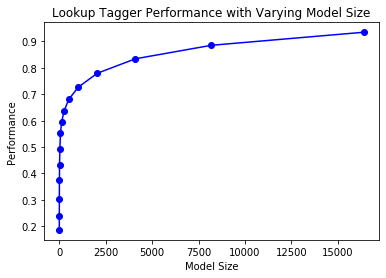

In [66]:
display()  

Observe that performance initially increases rapidly as the model size grows, eventually reaching a plateau, when large increases in model size yield little improvement in performance. (This example used the pylab plotting package)

# 4.4   Evaluation

Evaluating the performance of such tools is a central theme in NLP. Recall the processing pipeline in fig-sds; any errors in the output of one module are greatly multiplied in the downstream modules.


We evaluate the performance of a tagger relative to the tags a human expert would assign. Since we don't usually have access to an expert and impartial human judge, we make do instead with **gold standard** test data.

This is a corpus which has been manually annotated and which is accepted as a standard against which the guesses of an automatic system are assessed. The tagger is regarded as being correct if the tag it guesses for a given word is the same as the gold standard tag.

Of course, the humans who designed and carried out the original gold standard annotation were only human. Further analysis might show mistakes in the gold standard, or may eventually lead to a revised tagset and more elaborate guidelines. Nevertheless, the gold standard is by definition "correct" as far as the evaluation of an automatic tagger is concerned.

# 5   N-Gram Tagging
# 5.1   Unigram Tagging

Unigram taggers are based on a simple statistical algorithm: for each token, assign the tag that is most likely for that particular token. For example, it will assign the tag JJ to any occurrence of the word frequent, since frequent is used as an adjective (e.g. a frequent word) more often than it is used as a verb (e.g. I frequent this cafe).

A unigram tagger behaves just like a lookup tagger, except there is a more convenient technique for setting it up, called training. In the following code sample, we train a unigram tagger, use it to tag a sentence, then evaluate:

In [67]:
from nltk.corpus import brown
brown_tagged_sents = brown.tagged_sents(categories='news')
brown_sents = brown.sents(categories='news')
unigram_tagger = nltk.UnigramTagger(brown_tagged_sents)
unigram_tagger.tag(brown_sents[2007])

[('Various', 'JJ'),
 ('of', 'IN'),
 ('the', 'AT'),
 ('apartments', 'NNS'),
 ('are', 'BER'),
 ('of', 'IN'),
 ('the', 'AT'),
 ('terrace', 'NN'),
 ('type', 'NN'),
 (',', ','),
 ('being', 'BEG'),
 ('on', 'IN'),
 ('the', 'AT'),
 ('ground', 'NN'),
 ('floor', 'NN'),
 ('so', 'QL'),
 ('that', 'CS'),
 ('entrance', 'NN'),
 ('is', 'BEZ'),
 ('direct', 'JJ'),
 ('.', '.')]

In [68]:
unigram_tagger.evaluate(brown_tagged_sents)

0.9349006503968017

We train a UnigramTagger by specifying tagged sentence data as a parameter when we initialize the tagger. The training process involves inspecting the tag of each word and storing the most likely tag for any word in a dictionary, stored inside the tagger. This is exactly what we did before but this handles the model for and gets the most common for every word, not just the most common n. 

# 5.2   Separating the Training and Testing Data
Now that we are training a tagger on some data, we must not test it on the same data, as we did above. A tagger that simply memorized its training data and made no attempt to construct a general model would get a perfect score, but would also be useless for tagging new text. Instead, we should split the data, training on 90% and testing on the remaining 10%:

In [69]:
size = int(len(brown_tagged_sents) * 0.9)
size

4160

In [70]:
train_sents = brown_tagged_sents[:size]
test_sents = brown_tagged_sents[size:]
unigram_tagger = nltk.UnigramTagger(train_sents)
unigram_tagger.evaluate(test_sents)

0.8121200039868434

Although the score is worse, we now have a better picture of the usefulness of this tagger, i.e. its performance on previously unseen text.

# 5.3   General N-Gram Tagging

When we perform a language processing task based on unigrams, we are using one item of context. In the case of tagging, we only consider the current token, in isolation from any larger context. Given such a model, the best we can do is tag each word with its a priori most likely tag. This means we would tag a word such as wind with the same tag, regardless of whether it appears in the context the wind or to wind.

An n-gram tagger is a generalization of a unigram tagger whose context is the current word together with the part-of-speech tags of the n-1 preceding tokens. The tag to be chosen, tn, is circled, and the context is shaded in grey. We have n=3; that is, we consider the tags of the two preceding words in addition to the current word. An n-gram tagger picks the tag that is most likely in the given context.

The NgramTagger class uses a tagged training corpus to determine which part-of-speech tag is most likely for each context. Here we see a special case of an n-gram tagger, namely a bigram tagger. First we train it, then use it to tag untagged sentences:

In [71]:
bigram_tagger = nltk.BigramTagger(train_sents)
bigram_tagger.tag(brown_sents[2007])

[('Various', 'JJ'),
 ('of', 'IN'),
 ('the', 'AT'),
 ('apartments', 'NNS'),
 ('are', 'BER'),
 ('of', 'IN'),
 ('the', 'AT'),
 ('terrace', 'NN'),
 ('type', 'NN'),
 (',', ','),
 ('being', 'BEG'),
 ('on', 'IN'),
 ('the', 'AT'),
 ('ground', 'NN'),
 ('floor', 'NN'),
 ('so', 'CS'),
 ('that', 'CS'),
 ('entrance', 'NN'),
 ('is', 'BEZ'),
 ('direct', 'JJ'),
 ('.', '.')]

In [72]:
unseen_sent = brown_sents[4203]
bigram_tagger.tag(unseen_sent)

[('The', 'AT'),
 ('population', 'NN'),
 ('of', 'IN'),
 ('the', 'AT'),
 ('Congo', 'NP'),
 ('is', 'BEZ'),
 ('13.5', None),
 ('million', None),
 (',', None),
 ('divided', None),
 ('into', None),
 ('at', None),
 ('least', None),
 ('seven', None),
 ('major', None),
 ('``', None),
 ('culture', None),
 ('clusters', None),
 ("''", None),
 ('and', None),
 ('innumerable', None),
 ('tribes', None),
 ('speaking', None),
 ('400', None),
 ('separate', None),
 ('dialects', None),
 ('.', None)]

Notice that the bigram tagger manages to tag every word in a sentence it saw during training, but does badly on an unseen sentence. As soon as it encounters a new word (i.e., 13.5), it is unable to assign a tag. It cannot tag the following word (i.e., million) even if it was seen during training, simply because it never saw it during training with a None tag on the previous word. Consequently, the tagger fails to tag the rest of the sentence. Its overall accuracy score is very low:

In [73]:
bigram_tagger.evaluate(test_sents)

0.10206319146815508

As n gets larger, the specificity of the contexts increases, as does the chance that the data we wish to tag contains contexts that were not present in the training data. This is known as the sparse data problem, and is quite pervasive in NLP. As a consequence, there is a trade-off between the accuracy and the coverage of our results (and this is related to the precision/recall trade-off in information retrieval).

# 5.4   Combining Taggers

One way to address the trade-off between accuracy and coverage is to use the more accurate algorithms when we can, but to fall back on algorithms with wider coverage when necessary. For example, we could combine the results of a bigram tagger, a unigram tagger, and a default tagger, as follows:

Try tagging the token with the bigram tagger.
If the bigram tagger is unable to find a tag for the token, try the unigram tagger.
If the unigram tagger is also unable to find a tag, use a default tagger.
Most NLTK taggers permit a backoff-tagger to be specified. The backoff-tagger may itself have a backoff tagger:

In [74]:
t0 = nltk.DefaultTagger('NN')
t1 = nltk.UnigramTagger(train_sents, backoff=t0)
t2 = nltk.BigramTagger(train_sents, backoff=t1)
t3 = nltk.TrigramTagger(train_sents, backoff=t2)
t3.evaluate(test_sents)

0.843317053722715

We specify the backoff tagger when the tagger is initialized so that training can take advantage of the backoff tagger. Thus, if the bigram tagger would assign the same tag as its unigram backoff tagger in a certain context, the bigram tagger discards the training instance. This keeps the bigram tagger model as small as possible. 

We can further specify that a tagger needs to see more than one instance of a context in order to retain it, e.g. nltk.BigramTagger(sents, cutoff=2, backoff=t1) will discard contexts that have only been seen once or twice.

# 5.5   Tagging Unknown Words

Our approach to tagging unknown words still uses backoff to a regular-expression tagger or a default tagger. These are unable to make use of context. Thus, if our tagger encountered the word blog, not seen during training, it would assign it the same tag, regardless of whether this word appeared in the context the blog or to blog. How can we do better with these unknown words, or out-of-vocabulary items?

A useful method to tag unknown words based on context is to limit the vocabulary of a tagger to the most frequent n words, and to replace every other word with a special word UNK using the method shown in 3. During training, a unigram tagger will probably learn that UNK is usually a noun. However, the n-gram taggers will detect contexts in which it has some other tag. For example, if the preceding word is to (tagged TO), then UNK will probably be tagged as a verb.

In [75]:
from pickle import dump
output = open('t2.pkl', 'wb')
dump(t2, output, -1)
output.close()

In [76]:
from pickle import load
input = open('t2.pkl', 'rb')
tagger = load(input)
input.close()

In [77]:
text = """The board's action shows what free enterprise
   is up against in our complex maze of regulatory laws ."""
tokens = text.split()
tagger.tag(tokens)

[('The', 'AT'),
 ("board's", 'NN$'),
 ('action', 'NN'),
 ('shows', 'NNS'),
 ('what', 'WDT'),
 ('free', 'JJ'),
 ('enterprise', 'NN'),
 ('is', 'BEZ'),
 ('up', 'RP'),
 ('against', 'IN'),
 ('in', 'IN'),
 ('our', 'PP$'),
 ('complex', 'JJ'),
 ('maze', 'NN'),
 ('of', 'IN'),
 ('regulatory', 'NN'),
 ('laws', 'NNS'),
 ('.', '.')]

For coding interviews we can use a try catch statement. If we trained the modeled and sent it we try to load it. If it is not there, we train it. 

# 5.7   Performance Limitations
What is the upper limit to the performance of an n-gram tagger? Consider the case of a trigram tagger. How many cases of part-of-speech ambiguity does it encounter? We can determine the answer to this question empirically:

In [78]:
cfd = nltk.ConditionalFreqDist(
           ((x[1], y[1], z[0]), z[1])
           for sent in brown_tagged_sents
           for x, y, z in nltk.trigrams(sent))
ambiguous_contexts = [c for c in cfd.conditions() if len(cfd[c]) > 1]
sum(cfd[c].N() for c in ambiguous_contexts) / cfd.N()

0.049297702068029296

Thus, one out of twenty trigrams is ambiguous [EXAMPLES]. Given the current word and the previous two tags, in 5% of cases there is more than one tag that could be legitimately assigned to the current word according to the training data. Assuming we always pick the most likely tag in such ambiguous contexts, we can derive a lower bound on the performance of a trigram tagger.

Another way to investigate the performance of a tagger is to study its mistakes. Some tags may be harder than others to assign, and it might be possible to treat them specially by pre- or post-processing the data. A convenient way to look at tagging errors is the confusion matrix. It charts expected tags (the gold standard) against actual tags generated by a tagger:

In [79]:
from nltk.corpus import brown
import nltk
test_tags = [tag for sent in brown.sents(categories='editorial')
                 for (word, tag) in t2.tag(sent)]
gold_tags = [tag for (word, tag) in brown.tagged_words(categories='editorial')]
print(nltk.ConfusionMatrix(gold_tags, test_tags))    

           |                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

Based on such analysis we may decide to modify the tagset. Perhaps a distinction between tags that is difficult to make can be dropped, since it is not important in the context of some larger processing task.

Another way to analyze the performance bound on a tagger comes from the less than 100% agreement between human annotators. [MORE]

In general, observe that the tagging process collapses distinctions: e.g. lexical identity is usually lost when all personal pronouns are tagged PRP. At the same time, the tagging process introduces new distinctions and removes ambiguities: e.g. deal tagged as VB or NN. This characteristic of collapsing certain distinctions and introducing new distinctions is an important feature of tagging which facilitates classification and prediction. When we introduce finer distinctions in a tagset, an n-gram tagger gets more detailed information about the left-context when it is deciding what tag to assign to a particular word. However, the tagger simultaneously has to do more work to classify the current token, simply because there are more tags to choose from. Conversely, with fewer distinctions (as with the simplified tagset), the tagger has less information about context, and it has a smaller range of choices in classifying the current token.

We have seen that ambiguity in the training data leads to an upper limit in tagger performance. Sometimes more context will resolve the ambiguity. In other cases however, as noted by (Church, Young, & Bloothooft, 1996), the ambiguity can only be resolved with reference to syntax, or to world knowledge. Despite these imperfections, part-of-speech tagging has played a central role in the rise of statistical approaches to natural language processing. In the early 1990s, the surprising accuracy of statistical taggers was a striking demonstration that it was possible to solve one small part of the language understanding problem, namely part-of-speech disambiguation, without reference to deeper sources of linguistic knowledge. Can this idea be pushed further? In Chapter 7., we shall see that it can.

# 6   Transformation-Based Tagging

A potential issue with n-gram taggers is the size of their n-gram table (or language model). If tagging is to be employed in a variety of language technologies deployed on mobile computing devices, it is important to strike a balance between model size and tagger performance. An n-gram tagger with backoff may store trigram and bigram tables, large sparse arrays which may have hundreds of millions of entries.

A second issue concerns context. The only information an n-gram tagger considers from prior context is tags, even though words themselves might be a useful source of information. It is simply impractical for n-gram models to be conditioned on the identities of words in the context. In this section we examine Brill tagging, an inductive tagging method which performs very well using models that are only a tiny fraction of the size of n-gram taggers.

Brill tagging is a kind of transformation-based learning, named after its inventor. The general idea is very simple: guess the tag of each word, then go back and fix the mistakes. In this way, a Brill tagger successively transforms a bad tagging of a text into a better one. As with n-gram tagging, this is a supervised learning method, since we need annotated training data to figure out whether the tagger's guess is a mistake or not. However, unlike n-gram tagging, it does not count observations but compiles a list of transformational correction rules.

The process of Brill tagging is usually explained by analogy with painting. Suppose we were painting a tree, with all its details of boughs, branches, twigs and leaves, against a uniform sky-blue background. Instead of painting the tree first then trying to paint blue in the gaps, it is simpler to paint the whole canvas blue, then "correct" the tree section by over-painting the blue background. In the same fashion we might paint the trunk a uniform brown before going back to over-paint further details with even finer brushes. Brill tagging uses the same idea: begin with broad brush strokes then fix up the details, with successively finer changes. Let's look at an example involving the following sentence:

(1)		The President said he will ask Congress to increase grants to states for vocational rehabilitation

We will examine the operation of two rules: (a) Replace NN with VB when the previous word is TO; (b) Replace TO with IN when the next tag is NNS. 6.1 illustrates this process, first tagging with the unigram tagger, then applying the rules to fix the errors.

$$
\begin{array}{llllllll}
\hline \text { Phrase } & \text { to } & \text { increase } & \text { grants } & \text { to } & \text { states } & \text { for } & \text { vocational } & \text { rehabilitation } \\
\text { Unigram } & \text { TO } & N N & \text { NNS } & \text { TO } & \text { NNS } & \text { IN } & \text { JJ } & \text { NN } \\
\text { Rule 1 } & & V B & & & & & \\
\text { Rule 2 } & & & \text { IN } & & & & \\
\text { Output } &\text  & \text { TO } & \text { VB } & \text { NNS } & \text { IN } & \text { NNS } & \text { IN } & \text { JJ } & \text { NN } \\
{ Gold }& \text { TO } & \text { VB } & \text { NNS } & \text { IN } & \text { NNS } & \text { IN } & \text { JJ } & \text { NN } \\
\hline
\end{array}
$$

In this table we see two rules. All such rules are generated from a template of the following form: "replace T1 with T2 in the context C". Typical contexts are the identity or the tag of the preceding or following word, or the appearance of a specific tag within 2-3 words of the current word. During its training phase, the tagger guesses values for T1, T2 and C, to create thousands of candidate rules. Each rule is scored according to its net benefit: the number of incorrect tags that it corrects, less the number of correct tags it incorrectly modifies.

Brill taggers have another interesting property: the rules are linguistically interpretable. Compare this with the n-gram taggers, which employ a potentially massive table of n-grams. We cannot learn much from direct inspection of such a table, in comparison to the rules learned by the Brill tagger. 6.1 demonstrates NLTK's Brill tagger.

In [80]:
from nltk.tbl import demo as brill_demo
brill_demo.demo()

Loading tagged data from treebank... 
Read testing data (200 sents/5251 wds)
Read training data (800 sents/19933 wds)
Read baseline data (800 sents/19933 wds) [reused the training set]
Trained baseline tagger
    Accuracy on test set: 0.8366
Training tbl tagger...
TBL train (fast) (seqs: 800; tokens: 19933; tpls: 24; min score: 3; min acc: None)
Finding initial useful rules...
    Found 12799 useful rules.

           B      |
   S   F   r   O  |        Score = Fixed - Broken
   c   i   o   t  |  R     Fixed = num tags changed incorrect -> correct
   o   x   k   h  |  u     Broken = num tags changed correct -> incorrect
   r   e   e   e  |  l     Other = num tags changed incorrect -> incorrect
   e   d   n   r  |  e
------------------+-------------------------------------------------------
  23  23   0   0  | POS->VBZ if Pos:PRP@[-2,-1]
  18  19   1   0  | NN->VB if Pos:-NONE-@[-2] & Pos:TO@[-1]
  14  14   0   0  | VBP->VB if Pos:MD@[-2,-1]
  12  12   0   0  | VBP->VB if Pos:TO@[-1]
  

# 7   How to Determine the Category of a Word

Now that we have examined word classes in detail, we turn to a more basic question: how do we decide what category a word belongs to in the first place? In general, linguists use morphological, syntactic, and semantic clues to determine the category of a word.

# 7.1   Morphological Clues

The internal structure of a word may give useful clues as to the word's category. For example, -ness is a suffix that combines with an adjective to produce a noun, e.g. happy → happiness, ill → illness. So if we encounter a word that ends in -ness, this is very likely to be a noun. Similarly, -ment is a suffix that combines with some verbs to produce a noun, e.g. govern → government and establish → establishment.

English verbs can also be morphologically complex. For instance, the **present participle** of a verb ends in -ing, and expresses the idea of ongoing, incomplete action (e.g. falling, eating). The -ing suffix also appears on nouns derived from verbs, e.g. the falling of the leaves (this is known as the gerund).

# 7.2   Syntactic Clues

Another source of information is the typical contexts in which a word can occur. For example, assume that we have already determined the category of nouns. Then we might say that a syntactic criterion for an adjective in English is that it can occur immediately before a noun, or immediately following the words be or very. According to these tests, near should be categorized as an adjective:

(2)		
a.		the near window

b.		The end is (very) near.

# 7.3   Semantic Clues

Finally, the meaning of a word is a useful clue as to its lexical category. For example, the best-known definition of a noun is semantic: "the name of a person, place or thing". Within modern linguistics, semantic criteria for word classes are treated with suspicion, mainly because they are hard to formalize. Nevertheless, semantic criteria underpin many of our intuitions about word classes, and enable us to make a good guess about the categorization of words in languages that we are unfamiliar with. For example, if all we know about the Dutch word verjaardag is that it means the same as the English word birthday, then we can guess that verjaardag is a noun in Dutch. However, some care is needed: although we might translate zij is vandaag jarig as it's her birthday today, the word jarig is in fact an adjective in Dutch, and has no exact equivalent in English.

# 7.4   New Words

All languages acquire new lexical items. A list of words recently added to the Oxford Dictionary of English includes cyberslacker, fatoush, blamestorm, SARS, cantopop, bupkis, noughties, muggle, and robata. Notice that all these new words are nouns, and this is reflected in calling nouns an open class. By contrast, prepositions are regarded as a closed class. That is, there is a limited set of words belonging to the class (e.g., above, along, at, below, beside, between, during, for, from, in, near, on, outside, over, past, through, towards, under, up, with), and membership of the set only changes very gradually over time.

# 7.5   Morphology in Part of Speech Tagsets

Common tagsets often capture some [pmorpho-syntactic](https://en.wikipedia.org/wiki/Morphosyntactic_alignment) information; that is, information about the kind of morphological markings that words receive by virtue of their syntactic role. Consider, for example, the selection of distinct grammatical forms of the word go illustrated in the following sentences:

(3)		
a.		Go away!

b.		He sometimes _goes_ to the cafe.

c.		All the cakes have _gone_.

d.		We _went_ on the excursion.

Each of these forms — go, goes, gone, and went — is morphologically distinct from the others. Consider the form, goes. This occurs in a restricted set of grammatical contexts, and requires a third person singular subject. Thus, the following sentences are ungrammatical.

(4)		
a.		*They sometimes _goes_ to the cafe.

b.		*I sometimes _goes_ to the cafe.

By contrast, gone is the past participle form; it is required after have (and cannot be replaced in this context by goes), and cannot occur as the main verb of a clause.

(5)		
a.		*All the cakes have goes.

b.		*He sometimes gone to the cafe.

We can easily imagine a tagset in which the four distinct grammatical forms just discussed were all tagged as VB. Although this would be adequate for some purposes, a more fine-grained tagset provides useful information about these forms that can help other processors that try to detect patterns in tag sequences. The Brown tagset captures these distinction below

$$
\begin{array}{|lll|}
\hline {\text { Form }} &  {\text { Category }} &  {\text { Tag }} \\
\text { go } & \text { base } & \text { VB } \\
\text { goes } & \text { 3rd singular present } & \text { VBZ } \\
\text { gone } & \text { past participle } & \text { VBN } \\
\text { going } & \text { gerund } & \text { VBG } \\
\text { went } & \text { simple past } & \text { VBD } \\
\hline
\end{array}
$$

In addition to this set of verb tags, the various forms of the verb to be have special tags: be/BE, being/BEG, am/BEM, are/BER, is/BEZ, been/BEN, were/BED and was/BEDZ (plus extra tags for negative forms of the verb). All told, this fine-grained tagging of verbs means that an automatic tagger that uses this tagset is effectively carrying out a limited amount of morphological analysis.